In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
import bs4 as bs
import requests
import yfinance as yf
import seaborn as sns
import cvxpy as cp
from sklearn.cluster import AgglomerativeClustering
from quantstats import *

## Get Universe - Current S&P 500 stocks that exhisted in 2002

In [2]:
"""
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime(2000,1,1)
end = datetime(2022,1,1)
data = yf.download(tickers, start=start, end=end)

data.index = pd.to_datetime(data.index)
data = data.sort_index()
SP_Close = data['Adj Close']
SP_Close=SP_Close.dropna(axis=0, how='all')
SP_Close=SP_Close.dropna(axis=1)
pd.set_option('display.max_rows', 20 )
SP_Close
"""

"\nresp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')\nsoup = bs.BeautifulSoup(resp.text, 'lxml')\ntable = soup.find('table', {'class': 'wikitable sortable'})\ntickers = []\nfor row in table.findAll('tr')[1:]:\n    ticker = row.findAll('td')[0].text\n    tickers.append(ticker)\n\ntickers = [s.replace('\n', '') for s in tickers]\nstart = datetime(2000,1,1)\nend = datetime(2022,1,1)\ndata = yf.download(tickers, start=start, end=end)\n\ndata.index = pd.to_datetime(data.index)\ndata = data.sort_index()\nSP_Close = data['Adj Close']\nSP_Close=SP_Close.dropna(axis=0, how='all')\nSP_Close=SP_Close.dropna(axis=1)\npd.set_option('display.max_rows', 20 )\nSP_Close\n"

In [182]:
#read in stock data from pi
SP_Close = pd.read_pickle('SP_Close.pkl')
SP_train = SP_Close[:'2018-01-01']

In [4]:
SP_train.head()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,44.221344,0.854541,3.025873,18.25000,9.347846,16.274675,29.523603,6.713816,25.847561,8.052906,...,44.580296,1.278264,5.451855,12.421493,7.445602,19.671473,6.852272,4.861766,25.027779,38.801506
2000-01-04,40.843311,0.782494,2.819287,17.81250,9.080765,14.909398,28.030031,6.643880,25.847561,7.660817,...,42.912186,1.238933,5.508176,11.954857,7.617051,19.294680,6.852272,4.764044,24.666668,36.922596
2000-01-05,38.309803,0.793945,3.038025,18.00000,9.064073,15.204173,28.439224,6.538982,25.599024,7.178244,...,42.036430,1.219267,5.485648,12.588147,7.910958,20.346552,6.970727,4.788472,25.138889,36.878899
2000-01-06,36.851112,0.725238,3.268915,18.03125,9.381230,15.328291,27.661741,6.573946,25.940754,6.740914,...,42.495152,1.290063,5.429327,13.177001,7.837479,21.398418,6.979842,4.747756,23.777779,37.403233
2000-01-07,39.922039,0.759592,3.694239,17.93750,9.481387,16.072985,28.439224,6.678852,26.531029,7.540174,...,45.706272,1.270398,5.485648,12.743696,7.837479,21.335625,6.961617,4.641887,23.513889,37.490639


In [5]:
SP_train.tail()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-22,65.034782,41.731140,86.004715,191.639999,52.917374,175.000000,81.833565,35.416145,106.914101,103.889999,...,90.357903,28.866503,97.872253,29.092234,42.437065,66.389351,63.499165,76.503891,105.150002,45.769455
2017-12-26,64.938217,40.672424,86.739548,189.539993,52.982433,174.440002,81.630928,35.477833,107.545258,103.800003,...,91.231949,28.866503,97.528107,29.192152,42.067673,66.397224,63.923660,76.308914,104.790001,45.350365
2017-12-27,64.986504,40.679585,86.134933,190.419998,53.419315,175.360001,82.063828,35.460205,107.261719,104.580002,...,91.323959,28.931648,97.724762,29.225464,42.360115,66.333992,63.701767,76.503891,104.949997,45.216610
2017-12-28,65.131348,40.794033,86.125641,190.550003,53.410019,175.550003,82.321709,35.486645,107.307449,105.070000,...,91.452782,29.220720,97.360954,29.358677,42.608257,66.428864,64.173187,76.754570,104.279999,45.778381
2017-12-29,64.811005,40.352901,85.409393,187.410004,53.047497,175.240005,81.999352,35.319210,107.197662,104.830002,...,90.854729,29.171869,97.016815,29.358677,42.634838,66.128418,63.593575,75.770409,103.800003,45.323620


In [6]:
SP_test.tail()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,158.282700,179.836319,131.471329,357.829987,140.403183,577.679993,174.617828,65.720932,245.068527,284.299988,...,139.709854,54.160683,465.444122,38.111694,66.356621,61.211414,55.700321,137.372253,606.330017,62.687782
2021-12-28,158.721420,178.799164,131.929840,357.440002,139.420593,569.359985,173.533127,66.576385,244.849625,282.769989,...,141.714783,54.566757,464.425049,38.303886,67.151077,61.013607,55.779961,137.342392,597.320007,62.787273
2021-12-29,160.187180,178.888916,132.906647,361.839996,140.135193,569.289978,174.667587,66.655968,246.779999,282.570007,...,141.645309,54.932884,467.542084,39.091873,67.488716,60.479530,56.397194,138.019257,601.119995,63.125534
2021-12-30,160.416534,177.712143,133.335266,362.059998,139.946625,570.530029,173.931168,66.506760,244.342148,281.709991,...,142.101868,54.273849,470.888885,39.370552,67.756844,60.123474,56.058052,137.750504,597.539978,62.807171
2021-12-31,159.190079,177.083878,132.458115,359.170013,139.688568,567.059998,174.916367,67.232895,245.357101,281.190002,...,143.610519,54.846344,468.561127,39.572353,67.230515,60.519089,55.649090,138.218338,595.200012,62.837017


## Testing Initial Portfolio without Bayes

In [7]:
five_year_data=SP_Close[:1265] #5 years of data
five_year_data.tail()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-07,13.948145,1.057321,11.317923,14.29,15.050692,29.384233,23.419283,14.685472,22.294916,34.282318,...,37.189400,6.975882,10.584788,13.893993,9.064570,28.189127,24.471771,12.140292,53.099998,49.812916
2005-01-10,13.880588,1.052894,11.317923,14.42,15.196447,29.404230,23.327053,14.806506,22.310617,34.222351,...,37.003414,7.007394,10.730645,13.951578,9.189453,28.296703,25.020788,12.142917,53.840000,49.843578
2005-01-11,13.641056,0.985713,11.345287,14.31,14.917611,29.054298,23.109659,14.598061,22.352486,32.373302,...,36.913879,7.011895,10.605624,13.819960,9.220676,28.223104,25.020788,12.182205,51.669998,49.874241
2005-01-12,13.622632,0.999455,11.349197,14.17,14.952654,29.484215,23.425869,14.503919,22.148371,31.953520,...,37.251415,7.058410,10.684803,13.782939,9.210265,28.642065,24.935287,12.085085,50.910000,49.406685
2005-01-13,13.333963,1.065719,11.161545,12.45,14.665908,29.104290,23.122826,14.692193,21.719221,31.763618,...,36.948326,7.074916,10.605624,13.686286,9.298729,28.619408,24.669779,11.911839,51.060001,48.831833


In [125]:
mu = mean_historical_return(five_year_data)
S = CovarianceShrinkage(five_year_data).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
#ef.save_weights_to_file("weights.txt")  # saves to file
print(ef.portfolio_performance(verbose=True))

Expected annual return: 44.8%
Annual volatility: 13.6%
Sharpe Ratio: 3.15
(0.4481388941685276, 0.1359157033479189, 3.1500325835975826)


## Look at some correlations and clustering to gather ideas

<Figure size 864x576 with 0 Axes>

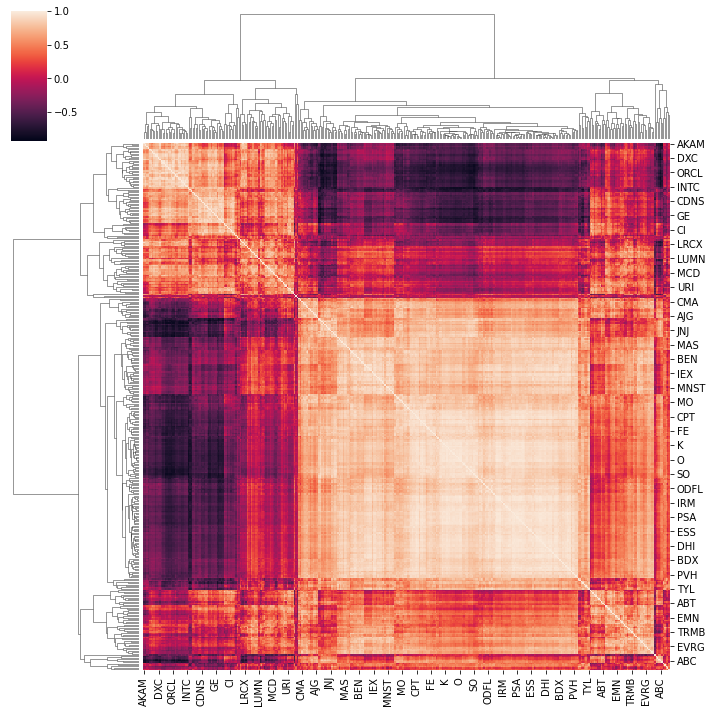

In [9]:
corr = five_year_data.corr()
plt.figure(figsize=(12,8))
sns.clustermap(corr)

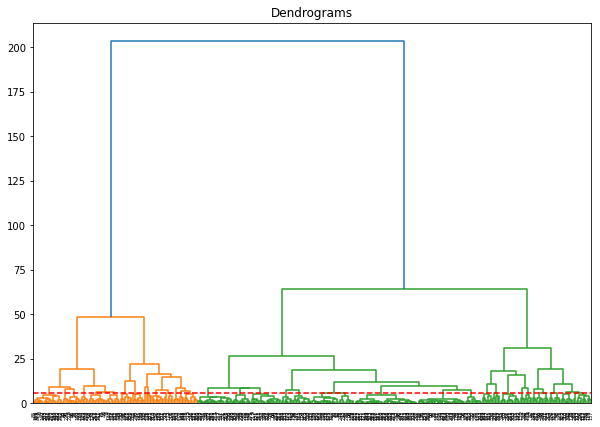

In [10]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(corr, method='ward'))
plt.axhline(y=6, color='r', linestyle='--')

In [11]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=4)  
kclusters = cluster.fit_predict(corr)
stock_clusters=pd.DataFrame(SP_Close.columns.values)
stock_clusters=stock_clusters.set_index(0)
stock_clusters['cluster']=kclusters
print(stock_clusters['cluster'].max())

64


In [12]:
#plt.hist(stock_clusters,bins=stock_clusters['cluster'].max())

In [13]:
#shrinkage
def calculate_posterior_mean(prior_pop, like_pop): #for returns use geo mean then multiply by 252 to annualize at end
    w0 = prior_pop.std()
    mu0 = prior_pop.mean() - w0**2/2
    w = like_pop.std()
    dbar = like_pop.mean() - w**2/2

    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    return mu_s * 252

## Markowitz Rebalancer

In [14]:
def Markowits_Bayes_Rebalance(securities_vector, rebalance_period,prior_period,update_period=0,verbose=True,weight_bounds=(-.01,.1)):
    #Bayesian update not yet implemented
    i=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    dates=[]
    for p in range(0,len(securities_vector)-prior_period,rebalance_period):
        
        prior_vector = securities_vector[p:prior_period+p]
        
        if verbose:
            print("Iteration " + str(i) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
            
        mu = mean_historical_return(prior_vector)
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        i+=1
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df

In [232]:
def Portfolio_backtest(weight_vector, securities_vector=SP_train,daily_rebalance = False,title=None):
    weight_vector_n = weight_vector
    weight_vector_n = weight_vector.reindex(weight_vector.index.union(securities_vector.index))
    weight_vector_n = weight_vector_n[weight_vector.index[0]:]
    return_frame = np.exp(np.log(securities_vector).diff())-1
    return_frame = return_frame[weight_vector.index[0]:]
    if daily_rebalance:
        weight_vector_n=weight_vector_n.ffill()
    else:
        for p in range(len(weight_vector_n)):
            if np.isnan(weight_vector_n.iloc[p,1]):
                new_weights_unnormalized = weight_vector_n.iloc[p-1,:]*(return_frame.iloc[p-1,:]+1)
                weight_vector_n.iloc[p,:] = new_weights_unnormalized/sum(new_weights_unnormalized)
                


    weighted_returns=weight_vector_n.shift(1)*return_frame
    port_returns = np.sum(weighted_returns, axis=1) #shift so that we are using the weights we had over that period rather than the ones we found with hindsight
    port_returns = port_returns[weight_vector.index[0]:]
    total_return=(port_returns+1).cumprod()
    total_return.plot()
    reports.metrics(port_returns,mode='basic')
    plt.title('Cumulative Return')
    if title != None:
        plt.title(title)
        plt.savefig(title)
    return total_return

In [154]:
monthly_vanilla_markowitz = Markowits_Bayes_Rebalance(SP_train,63,253*4,weight_bounds=(-.002,.2),verbose=False) 

                    Strategy
------------------  ----------
Start Period        2004-01-13
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   656.47%
CAGR﹪              15.59%

Sharpe              0.94
Sortino             1.37
Sortino/√2          0.97
Omega               1.18

Max Drawdown        -50.04%
Longest DD Days     1300

Gain/Pain Ratio     0.18
Gain/Pain (1M)      1.25

Payoff Ratio        0.96
Profit Factor       1.18
Common Sense Ratio  1.18
CPC Index           0.62
Tail Ratio          1.0
Outlier Win Ratio   3.36
Outlier Loss Ratio  3.48

MTD                 -1.87%
3M                  10.77%
6M                  17.01%
YTD                 41.25%
1Y                  40.68%
3Y (ann.)           17.27%
5Y (ann.)           20.13%
10Y (ann.)          11.15%
All-time (ann.)     15.59%

Avg. Drawdown       -2.51%
Avg. Drawdown Days  27
Recovery Factor     13.12
Ulcer Index         0.17
Serenity Index      1.23


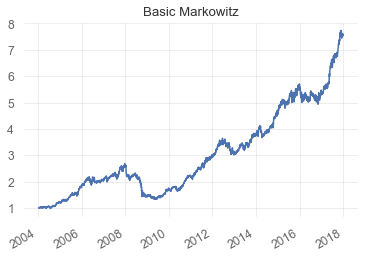

In [248]:
bm =Portfolio_backtest(monthly_vanilla_markowitz,title='Basic Markowitz')


                    Strategy
------------------  ----------
Start Period        2004-01-13
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   586.87%
CAGR﹪              14.79%

Sharpe              0.81
Sortino             1.15
Sortino/√2          0.81
Omega               1.17

Max Drawdown        -50.16%
Longest DD Days     1077

Gain/Pain Ratio     0.17
Gain/Pain (1M)      1.35

Payoff Ratio        0.9
Profit Factor       1.17
Common Sense Ratio  1.12
CPC Index           0.59
Tail Ratio          0.96
Outlier Win Ratio   4.49
Outlier Loss Ratio  4.15

MTD                 0.48%
3M                  7.81%
6M                  10.94%
YTD                 26.68%
1Y                  26.15%
3Y (ann.)           13.11%
5Y (ann.)           19.2%
10Y (ann.)          13.45%
All-time (ann.)     14.79%

Avg. Drawdown       -1.74%
Avg. Drawdown Days  18
Recovery Factor     11.7
Ulcer Index         0.11
Serenity Index      3.17


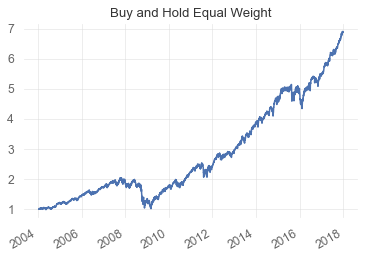

In [247]:
bnh = monthly_vanilla_markowitz.iloc[0:2,:]
bnh.iloc[0,:] = 1/367
bnh.iloc[1,:] = 1/367
bnh = Portfolio_backtest(bnh,title='Buy and Hold Equal Weight')

## Implement Clustering Influenced Dynamic Constraints

In [18]:
def Cluster_Constraints(clusters,u_coef,l_coef): # weight coef for how overweight you can go
    cluster_list = set(clusters.cluster)
    cluster_map = dict(zip(clusters.index,clusters.cluster))
    cluster_totals=[clusters.value_counts()[x] for x in cluster_list]
    cluster_pct=np.array(cluster_totals)/len(clusters)
    cluster_upper_l = dict(zip(cluster_list, cluster_pct*u_coef))
    cluster_lower_l = dict(zip(cluster_list, - l_coef*cluster_pct))
    return cluster_map, cluster_upper_l, cluster_lower_l

In [19]:
#for testing preset clusters
def get_clusters(corr, cluster_number = 45, Thresh = None):
    if Thresh == None:
        cluster = AgglomerativeClustering(n_clusters=cluster_number, affinity='euclidean', linkage='ward')
    else:
        cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=Thresh) 
    kclusters = cluster.fit_predict(corr)
    stock_clusters=pd.DataFrame(SP_Close.columns.values)
    stock_clusters=stock_clusters.set_index(0)
    stock_clusters['cluster']=kclusters
    return stock_clusters

In [20]:
class constrained_clusterings_precomputed:
    
    def __init__(self,lookback):
        llist = [1,2,3,4,5]
        if (int(lookback) != lookback) or (int(lookback) not in llist):
            raise ValueError("Only lookback periods of",llist,"supported")
            
        self.df = pd.read_pickle(str(int(lookback))+'.pkl')
        self.names_df = pd.read_pickle('names.pkl')
        
#         corr_threshold = 0.7
#         pct_threshold = 0.1
#         date = datetime.strptime('3-31-2030','%m-%d-%Y')
        
            
    def calcthresholds(self,corr_threshold,pct_threshold,date,DEBUG=False):
        if date < min(self.df.index):
            raise ValueError("Date must be >=",min(self.df.index))
        if date > max(self.df.index):
            print("WARNING: USING",max(self.df.index),"FOR INPUT DATE",date)
        inddate = max(self.df.index[self.df.index <= date])
#         print(inddate)
#         print(self.df.loc[inddate])
        if DEBUG:
            print("DEBUG: USING",inddate,"FOR INPUT DATE",date)
        
        clusters = self.df.loc[inddate]['Clusters']
        numstocks = self.df.loc[inddate]['Numstocks']
        internals = self.df.loc[inddate]['Corrs']
        sz = clusters.shape[0]
        
        tmp = np.sum((internals<corr_threshold)*(numstocks/sz),axis=1)<pct_threshold
        ret = (np.arange(0,sz)+1)[tmp]
        if ret.shape[0] <= 0:
            return None
        OPTIMAL_NUMBER_OF_CLUSTERS = ret[0]
        if DEBUG:
            print("DEBUG: OPTIMAL NUMBER OF CLUSTERS:",OPTIMAL_NUMBER_OF_CLUSTERS)
        
        ret_df = self.names_df
        ret_df = ret_df.set_index(0)
        ret_df['cluster'] = clusters[OPTIMAL_NUMBER_OF_CLUSTERS-1,:].astype(int)
        
#         print(OPTIMAL_NUMBER_OF_CLUSTERS)
#         print(ret_df)
        return ret_df

In [21]:
import os
filelist = ['1.pkl','2.pkl','3.pkl','4.pkl','5.pkl','names.pkl']
for file in filelist:
    if not os.path.exists(file):
        raise ValueError("All of",filelist,"must be present")
        
look1 = constrained_clusterings_precomputed(1)
look2 = constrained_clusterings_precomputed(2)
look3 = constrained_clusterings_precomputed(3)
look4 = constrained_clusterings_precomputed(4)
look5 = constrained_clusterings_precomputed(5)

In [22]:
def get_clusters_precomputed(lookback,corr_threshold,pct_threshold,date,DEBUG=False):
    llist = [1,2,3,4,5]
    if (int(lookback) != lookback) or (int(lookback) not in llist):
        raise ValueError("Only lookback periods of",llist,"supported")
        
    # Apparently pattern matching wasn't implemented until Python 3.10
    if lookback == 1:
        return look1.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 2:
        return look2.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 3:
        return look3.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 4:
        return look4.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 5:
        return look5.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    else:
        raise ValueError("Something went wrong")

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
def Markowits_Bayes_Cluster_Rebalance(securities_vector, rebalance_period=21,prior_period = 253*5, update_period=0,
                                      verbose=False,weight_bounds=(-.005,.15), cluster_u_coef=2, cluster_l_coef=-.05,
                                      corr_thresh = .75,leave_out_pct = .05, clust_num = None, reverse_prior=False):
    z=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    dates=[]
    cluster_list=[]
    num=clust_num
    for p in range(0,len(securities_vector)-prior_period,rebalance_period):
        
        prior_vector = securities_vector[p:prior_period+p]
        update_vector = securities_vector[prior_period+p-update_period:prior_period+p]
        if verbose:
            print("Iteration " + str(z) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
        
        if clust_num == None:
            clusters= get_clusters_precomputed(prior_period/253,corr_thresh, leave_out_pct, date=prior_vector.index[-1])
            num = clusters.max().values[0]
            cluster_list.append(max(clusters))    
        else:
            clusters = get_clusters(prior_vector.corr(), cluster_number = clust_num)
            cluster_list.append(clust_num) 
        c_map, c_upper, c_lower = Cluster_Constraints(clusters,cluster_u_coef,cluster_l_coef)
        mu = mean_historical_return(prior_vector)  
        if update_period != 0:
            if reverse_prior:
                for i in range(num):
                    stocksNcluster = clusters.loc[clusters['cluster']==i].index
                    for stock in stocksNcluster:
                        mu.loc[stock] = calculate_posterior_mean(prior_vector[stock].pct_change().dropna().to_numpy(),
                                                                 update_vector[stocksNcluster].pct_change().dropna().to_numpy())
            else:
                for i in range(num):
                    stocksNcluster = clusters.loc[clusters['cluster']==i].index
                    for stock in stocksNcluster:
                        mu.loc[stock] = calculate_posterior_mean(prior_vector[stocksNcluster].pct_change().dropna().to_numpy(),
                                                                 update_vector[stock].pct_change().dropna().to_numpy())
            
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        if cluster_u_coef<100 and cluster_l_coef>-100: ef.add_sector_constraints(c_map, c_lower, c_upper)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        z+=1
    cluster_ts=pd.DataFrame(cluster_list)
    cluster_ts.index=dates
    cluster_ts.columns = ['Clusters']
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df, cluster_ts

## Shrinkage without cluster constraints

In [204]:
returns_shrinkage_C, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*4,21*3, weight_bounds=(-.002,.2), cluster_u_coef=1000, cluster_l_coef=-1000,clust_num=50,verbose=False) 

                    Strategy
------------------  ----------
Start Period        2004-01-13
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   280.84%
CAGR﹪              10.05%

Sharpe              0.72
Sortino             1.02
Sortino/√2          0.72
Omega               1.13

Max Drawdown        -42.74%
Longest DD Days     1635

Gain/Pain Ratio     0.13
Gain/Pain (1M)      0.8

Payoff Ratio        0.94
Profit Factor       1.13
Common Sense Ratio  1.1
CPC Index           0.58
Tail Ratio          0.97
Outlier Win Ratio   3.36
Outlier Loss Ratio  3.53

MTD                 0.56%
3M                  13.19%
6M                  14.63%
YTD                 25.95%
1Y                  25.15%
3Y (ann.)           13.2%
5Y (ann.)           17.88%
10Y (ann.)          8.96%
All-time (ann.)     10.05%

Avg. Drawdown       -2.54%
Avg. Drawdown Days  34
Recovery Factor     6.57
Ulcer Index         0.14
Serenity Index      0.68


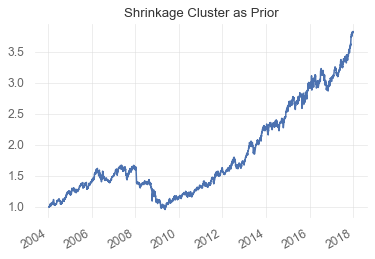

In [233]:
c_p = Portfolio_backtest(returns_shrinkage_C,title='Shrinkage Cluster as Prior')

## Shrinkage with stock as prior and cluster as likelihood

In [27]:
returns_shrinkage, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*4,21*3, weight_bounds=(-.002,.2), cluster_u_coef=1000, cluster_l_coef=-1000,clust_num=50,verbose=False, reverse_prior=True) 

                    Strategy
------------------  ----------
Start Period        2004-01-13
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   602.21%
CAGR﹪              14.97%

Sharpe              1.04
Sortino             1.49
Sortino/√2          1.05
Omega               1.2

Max Drawdown        -42.83%
Longest DD Days     1219

Gain/Pain Ratio     0.2
Gain/Pain (1M)      1.28

Payoff Ratio        0.95
Profit Factor       1.2
Common Sense Ratio  1.16
CPC Index           0.63
Tail Ratio          0.97
Outlier Win Ratio   3.18
Outlier Loss Ratio  3.44

MTD                 0.36%
3M                  13.27%
6M                  13.17%
YTD                 26.62%
1Y                  26.14%
3Y (ann.)           12.86%
5Y (ann.)           16.48%
10Y (ann.)          11.49%
All-time (ann.)     14.97%

Avg. Drawdown       -2.18%
Avg. Drawdown Days  27
Recovery Factor     14.06
Ulcer Index         0.13
Serenity Index      1.78


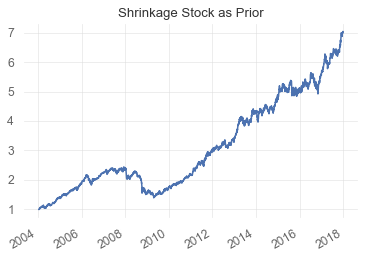

In [235]:
s_p = Portfolio_backtest(returns_shrinkage,title = 'Shrinkage Stock as Prior')

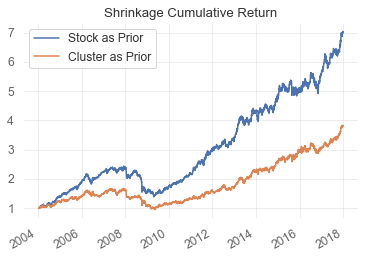

In [242]:
s_p.plot(label='Stock as Prior')
c_p.plot(label='Cluster as Prior')
plt.legend()
plt.title('Shrinkage Cumulative Return')
plt.savefig('stock vs cluster')

## Shrinkage and dynamic clusters

In [29]:
returns_shrinkage_dy, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*4,21*3, weight_bounds=(-.002,.2), cluster_u_coef=1000, cluster_l_coef=-1000,verbose=False) 

                    Strategy
------------------  ----------
Start Period        2004-01-13
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   258.69%
CAGR﹪              9.57%

Sharpe              0.69
Sortino             0.98
Sortino/√2          0.69
Omega               1.13

Max Drawdown        -43.82%
Longest DD Days     1645

Gain/Pain Ratio     0.13
Gain/Pain (1M)      0.73

Payoff Ratio        0.94
Profit Factor       1.13
Common Sense Ratio  1.08
CPC Index           0.58
Tail Ratio          0.96
Outlier Win Ratio   3.34
Outlier Loss Ratio  3.61

MTD                 0.52%
3M                  13.3%
6M                  14.61%
YTD                 27.98%
1Y                  27.15%
3Y (ann.)           12.86%
5Y (ann.)           17.86%
10Y (ann.)          8.56%
All-time (ann.)     9.57%

Avg. Drawdown       -2.55%
Avg. Drawdown Days  35
Recovery Factor     5.9
Ulcer Index         0.15
Serenity Index      0.56


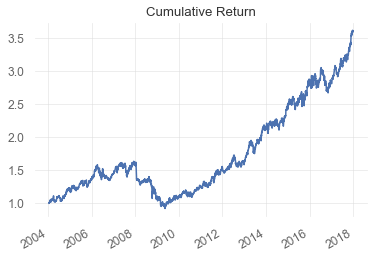

In [158]:
Portfolio_backtest(returns_shrinkage_dy,title='Shrinkage Dynamic Clusters ')

## With static Cluster Constraints no shrinkage

In [31]:
returns_static, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*4, weight_bounds=(-.002,.2), cluster_u_coef=3, cluster_l_coef=-.05,clust_num=50,verbose=False)

                    Strategy
------------------  ----------
Start Period        2004-01-13
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   712.3%
CAGR﹪              16.18%

Sharpe              0.99
Sortino             1.44
Sortino/√2          1.02
Omega               1.19

Max Drawdown        -49.12%
Longest DD Days     1232

Gain/Pain Ratio     0.19
Gain/Pain (1M)      1.38

Payoff Ratio        0.95
Profit Factor       1.19
Common Sense Ratio  1.18
CPC Index           0.63
Tail Ratio          0.99
Outlier Win Ratio   3.53
Outlier Loss Ratio  3.65

MTD                 -1.25%
3M                  10.51%
6M                  16.67%
YTD                 36.75%
1Y                  36.37%
3Y (ann.)           16.22%
5Y (ann.)           21.37%
10Y (ann.)          11.62%
All-time (ann.)     16.18%

Avg. Drawdown       -2.29%
Avg. Drawdown Days  25
Recovery Factor     14.5
Ulcer Index         0.14
Serenity Index      1.9


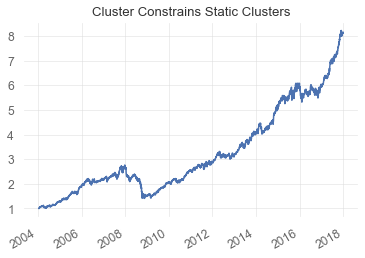

In [220]:
Portfolio_backtest(returns_static, title='Cluster Constrains Static Clusters')

## dynamic cluster constraints no shrinkage

In [33]:
returns_dynamic, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*4, weight_bounds=(-.002,.2), cluster_u_coef=3, cluster_l_coef=-.05,verbose=False)

                    Strategy
------------------  ----------
Start Period        2004-01-13
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   649.37%
CAGR﹪              15.51%

Sharpe              0.96
Sortino             1.38
Sortino/√2          0.98
Omega               1.18

Max Drawdown        -50.85%
Longest DD Days     1490

Gain/Pain Ratio     0.18
Gain/Pain (1M)      1.28

Payoff Ratio        0.95
Profit Factor       1.18
Common Sense Ratio  1.16
CPC Index           0.63
Tail Ratio          0.98
Outlier Win Ratio   3.47
Outlier Loss Ratio  3.54

MTD                 -1.22%
3M                  11.97%
6M                  18.64%
YTD                 38.75%
1Y                  38.26%
3Y (ann.)           16.61%
5Y (ann.)           21.23%
10Y (ann.)          11.14%
All-time (ann.)     15.51%

Avg. Drawdown       -2.28%
Avg. Drawdown Days  25
Recovery Factor     12.77
Ulcer Index         0.16
Serenity Index      1.4


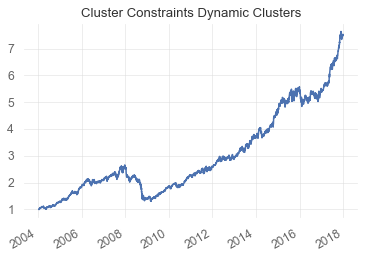

In [253]:
dyn_clust =Portfolio_backtest(returns_dynamic, title='Cluster Constraints Dynamic Clusters')

## Use Shrinkage and Cluster constraints

In [36]:
returns_s, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*4,21*3, weight_bounds=(-.002,.2), cluster_u_coef=3, cluster_l_coef=-.05,verbose=False)

                    Strategy
------------------  ----------
Start Period        2004-01-13
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   275.65%
CAGR﹪              9.94%

Sharpe              0.72
Sortino             1.02
Sortino/√2          0.72
Omega               1.13

Max Drawdown        -41.28%
Longest DD Days     1868

Gain/Pain Ratio     0.13
Gain/Pain (1M)      0.91

Payoff Ratio        0.94
Profit Factor       1.13
Common Sense Ratio  1.08
CPC Index           0.58
Tail Ratio          0.95
Outlier Win Ratio   3.41
Outlier Loss Ratio  3.66

MTD                 0.53%
3M                  13.96%
6M                  14.38%
YTD                 25.7%
1Y                  25.1%
3Y (ann.)           13.69%
5Y (ann.)           19.45%
10Y (ann.)          9.66%
All-time (ann.)     9.94%

Avg. Drawdown       -2.19%
Avg. Drawdown Days  34
Recovery Factor     6.68
Ulcer Index         0.13
Serenity Index      0.75


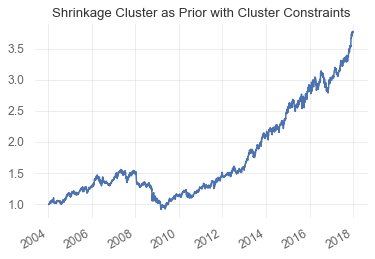

In [223]:
Portfolio_backtest(returns_s,title= 'Shrinkage Cluster as Prior with Cluster Constraints')

## shrinkage and static clusters stock as prior

In [320]:
returns_shrink_stat_rev, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*4,21*3, weight_bounds=(-.002,.2), cluster_u_coef=3, cluster_l_coef=-.05,clust_num=50,verbose=False,reverse_prior=True)

                    Strategy
------------------  ----------
Start Period        2004-01-13
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   719.59%
CAGR﹪              16.25%

Sharpe              1.19
Sortino             1.72
Sortino/√2          1.22
Omega               1.23

Max Drawdown        -34.77%
Longest DD Days     1013

Gain/Pain Ratio     0.23
Gain/Pain (1M)      2.02

Payoff Ratio        0.96
Profit Factor       1.23
Common Sense Ratio  1.23
CPC Index           0.66
Tail Ratio          1.0
Outlier Win Ratio   3.26
Outlier Loss Ratio  3.58

MTD                 0.2%
3M                  11.23%
6M                  13.05%
YTD                 27.11%
1Y                  26.71%
3Y (ann.)           13.63%
5Y (ann.)           19.77%
10Y (ann.)          12.57%
All-time (ann.)     16.25%

Avg. Drawdown       -1.53%
Avg. Drawdown Days  18
Recovery Factor     20.69
Ulcer Index         0.09
Serenity Index      4.21


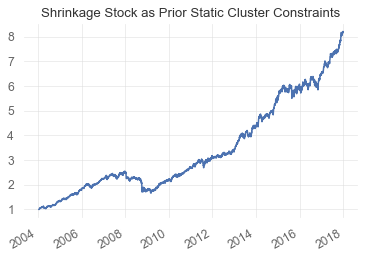

In [321]:
best1 = Portfolio_backtest(returns_shrink_stat_rev, title='Shrinkage Stock as Prior Static Cluster Constraints')

## Shrinkage and Cluster Constraints Stock as Prior

In [318]:
returns_shrink_dyn_rev, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*4,21*3, weight_bounds=(-.002,.2), cluster_u_coef=3, cluster_l_coef=-.05,verbose=False,reverse_prior=True)

                    Strategy
------------------  ----------
Start Period        2004-01-13
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   775.97%
CAGR﹪              16.81%

Sharpe              1.23
Sortino             1.78
Sortino/√2          1.26
Omega               1.24

Max Drawdown        -34.66%
Longest DD Days     1013

Gain/Pain Ratio     0.24
Gain/Pain (1M)      2.29

Payoff Ratio        0.96
Profit Factor       1.24
Common Sense Ratio  1.24
CPC Index           0.67
Tail Ratio          1.0
Outlier Win Ratio   3.36
Outlier Loss Ratio  3.52

MTD                 -0.45%
3M                  11.87%
6M                  13.98%
YTD                 24.81%
1Y                  24.74%
3Y (ann.)           16.5%
5Y (ann.)           22.26%
10Y (ann.)          14.17%
All-time (ann.)     16.81%

Avg. Drawdown       -1.58%
Avg. Drawdown Days  17
Recovery Factor     22.39
Ulcer Index         0.09
Serenity Index      4.61


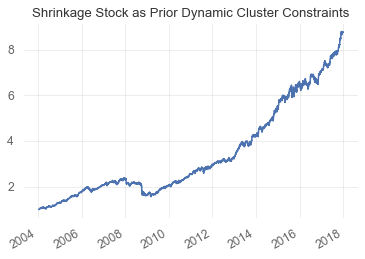

In [319]:
best = Portfolio_backtest(returns_shrink_dyn_rev, title='Shrinkage Stock as Prior Dynamic Cluster Constraints')

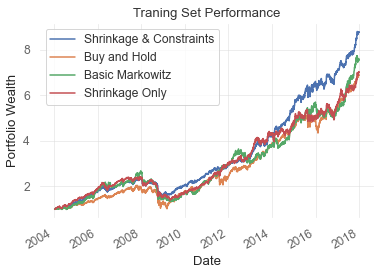

In [256]:
best.plot(label='Shrinkage & Constraints')
bnh.plot(label='Buy and Hold')
bm.plot(label='Basic Markowitz')
s_p.plot(label='Shrinkage Only')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Portfolio Wealth')
plt.title('Traning Set Performance')
plt.savefig('Model Comparison')

## Try this one with monthly since its best we got

In [180]:
returns_shrink_dyn_rev_monthly, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21,253*3,21*3, weight_bounds=(-.002,.2), cluster_u_coef=3, cluster_l_coef=-.05,verbose=False,reverse_prior=True)

                    Strategy
------------------  ----------
Start Period        2003-01-10
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   743.91%
CAGR﹪              15.3%

Sharpe              1.18
Sortino             1.68
Sortino/√2          1.18
Omega               1.22

Max Drawdown        -32.94%
Longest DD Days     1036

Gain/Pain Ratio     0.22
Gain/Pain (1M)      1.96

Payoff Ratio        0.92
Profit Factor       1.22
Common Sense Ratio  1.18
CPC Index           0.64
Tail Ratio          0.96
Outlier Win Ratio   3.41
Outlier Loss Ratio  3.46

MTD                 0.45%
3M                  9.69%
6M                  7.51%
YTD                 20.79%
1Y                  20.8%
3Y (ann.)           14.27%
5Y (ann.)           17.98%
10Y (ann.)          11.74%
All-time (ann.)     15.3%

Avg. Drawdown       -1.65%
Avg. Drawdown Days  21
Recovery Factor     22.58
Ulcer Index         0.09
Serenity Index      4.21


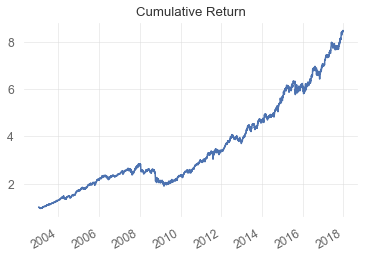

In [181]:
Portfolio_backtest(returns_shrink_dyn_rev_monthly)

## Shrinkage and Cluster Constraints Stock as Prior static clusters

In [169]:
returns_shrink_stat_rev, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*4,21*3, weight_bounds=(-.002,.2), cluster_u_coef=3, cluster_l_coef=-.05,clust_num = 50,verbose=False,reverse_prior=True)

                    Strategy
------------------  ----------
Start Period        2004-01-13
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   719.6%
CAGR﹪              16.25%

Sharpe              1.19
Sortino             1.72
Sortino/√2          1.22
Omega               1.23

Max Drawdown        -34.77%
Longest DD Days     1013

Gain/Pain Ratio     0.23
Gain/Pain (1M)      2.02

Payoff Ratio        0.96
Profit Factor       1.23
Common Sense Ratio  1.23
CPC Index           0.66
Tail Ratio          1.0
Outlier Win Ratio   3.26
Outlier Loss Ratio  3.58

MTD                 0.2%
3M                  11.23%
6M                  13.05%
YTD                 27.11%
1Y                  26.71%
3Y (ann.)           13.63%
5Y (ann.)           19.77%
10Y (ann.)          12.57%
All-time (ann.)     16.25%

Avg. Drawdown       -1.53%
Avg. Drawdown Days  18
Recovery Factor     20.69
Ulcer Index         0.09
Serenity Index      4.21


2004-01-13    1.000000
2004-01-14    0.999156
2004-01-15    0.996333
2004-01-16    0.995927
2004-01-20    0.998805
                ...   
2017-12-22    8.174967
2017-12-26    8.175253
2017-12-27    8.183706
2017-12-28    8.218045
2017-12-29    8.196049
Length: 3517, dtype: float64

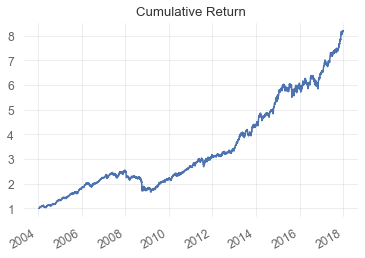

In [316]:
Portfolio_backtest(returns_shrink_stat_rev)

## Using optimal hyperparameters

### Cluster as prior 3 month update

In [343]:
returns_opt_3, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*3,21*3,corr_thresh=.75, weight_bounds=(-.002,.1), clust_num=50,cluster_u_coef=4, cluster_l_coef=-.05,verbose=False,reverse_prior=True)

                    Strategy
------------------  ----------
Start Period        2003-01-10
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   963.11%
CAGR﹪              17.1%

Sharpe              1.29
Sortino             1.89
Sortino/√2          1.33
Omega               1.25

Max Drawdown        -32.32%
Longest DD Days     1015

Gain/Pain Ratio     0.25
Gain/Pain (1M)      2.23

Payoff Ratio        0.98
Profit Factor       1.25
Common Sense Ratio  1.27
CPC Index           0.69
Tail Ratio          1.01
Outlier Win Ratio   3.26
Outlier Loss Ratio  3.69

MTD                 -0.43%
3M                  10.59%
6M                  8.61%
YTD                 22.63%
1Y                  22.29%
3Y (ann.)           15.93%
5Y (ann.)           19.89%
10Y (ann.)          13.29%
All-time (ann.)     17.1%

Avg. Drawdown       -1.62%
Avg. Drawdown Days  18
Recovery Factor     29.8
Ulcer Index         0.08
Serenity Index      6.23


2003-01-10     1.000000
2003-01-13     0.999121
2003-01-14     1.003592
2003-01-15     1.000085
2003-01-16     1.000274
                ...    
2017-12-22    10.616248
2017-12-26    10.617864
2017-12-27    10.634690
2017-12-28    10.656283
2017-12-29    10.631095
Length: 3770, dtype: float64

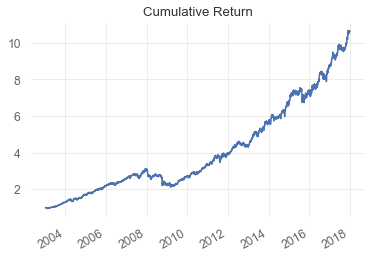

In [344]:
Portfolio_backtest(returns_opt_3)

### Markowitz

In [345]:
returns_opt_m, _ = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*3, weight_bounds=(-.002,.1))

                    Strategy
------------------  ----------
Start Period        2003-01-10
End Period          2017-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   1,231.92%
CAGR﹪              18.87%

Sharpe              1.2
Sortino             1.75
Sortino/√2          1.24
Omega               1.23

Max Drawdown        -40.76%
Longest DD Days     1287

Gain/Pain Ratio     0.23
Gain/Pain (1M)      1.88

Payoff Ratio        0.95
Profit Factor       1.23
Common Sense Ratio  1.22
CPC Index           0.66
Tail Ratio          0.99
Outlier Win Ratio   3.38
Outlier Loss Ratio  3.41

MTD                 -0.63%
3M                  11.55%
6M                  17.91%
YTD                 38.59%
1Y                  38.54%
3Y (ann.)           20.14%
5Y (ann.)           24.72%
10Y (ann.)          13.41%
All-time (ann.)     18.87%

Avg. Drawdown       -2.13%
Avg. Drawdown Days  21
Recovery Factor     30.22
Ulcer Index         0.11
Serenity Index      4.8


2003-01-10     1.000000
2003-01-13     0.998671
2003-01-14     0.998543
2003-01-15     1.000549
2003-01-16     1.002426
                ...    
2017-12-22    13.296296
2017-12-26    13.306130
2017-12-27    13.307205
2017-12-28    13.373276
2017-12-29    13.319208
Length: 3770, dtype: float64

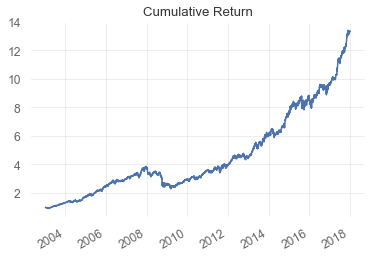

In [346]:
Portfolio_backtest(returns_opt_m)

## Test Data

In [347]:
SP_test =  SP_Close['2014-01-01':]

In [348]:
vanilla_markowitz_test = Markowits_Bayes_Rebalance(SP_test,63,253*3,weight_bounds=(-.002,.1),verbose=False) 
vanilla_markowitz_test =  vanilla_markowitz_test['2018-01-01':]

In [349]:
shrink_test, _ = Markowits_Bayes_Cluster_Rebalance(SP_test,21*3,253*3,21*3,corr_thresh=.75, weight_bounds=(-.002,.1), clust_num=50,cluster_u_coef=4, cluster_l_coef=-.05,verbose=False,reverse_prior=True)
shrink_test =  shrink_test['2018-01-01':]

                    Strategy
------------------  ----------
Start Period        2018-01-05
End Period          2021-12-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   84.61%
CAGR﹪              16.61%

Sharpe              0.76
Sortino             1.06
Sortino/√2          0.75
Omega               1.16

Max Drawdown        -34.56%
Longest DD Days     336

Gain/Pain Ratio     0.16
Gain/Pain (1M)      1.42

Payoff Ratio        0.91
Profit Factor       1.16
Common Sense Ratio  1.01
CPC Index           0.59
Tail Ratio          0.87
Outlier Win Ratio   4.01
Outlier Loss Ratio  4.0

MTD                 6.45%
3M                  12.86%
6M                  18.01%
YTD                 25.27%
1Y                  25.73%
3Y (ann.)           22.89%
5Y (ann.)           16.61%
10Y (ann.)          16.61%
All-time (ann.)     16.61%

Avg. Drawdown       -3.51%
Avg. Drawdown Days  26
Recovery Factor     2.45
Ulcer Index         0.08
Serenity Index      1.22


2018-01-05    1.000000
2018-01-08    1.005655
2018-01-09    1.011833
2018-01-10    1.005885
2018-01-11    1.013567
                ...   
2021-12-27    1.815891
2021-12-28    1.817082
2021-12-29    1.834825
2021-12-30    1.839091
2021-12-31    1.846082
Length: 1005, dtype: float64

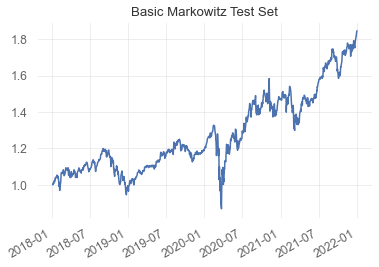

In [350]:
Portfolio_backtest(vanilla_markowitz_test,securities_vector=SP_test,title = 'Basic Markowitz Test Set')

                    Strategy
------------------  ----------
Start Period        2018-01-05
End Period          2021-12-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   67.21%
CAGR﹪              13.76%

Sharpe              0.75
Sortino             1.04
Sortino/√2          0.74
Omega               1.17

Max Drawdown        -35.82%
Longest DD Days     263

Gain/Pain Ratio     0.17
Gain/Pain (1M)      1.09

Payoff Ratio        0.93
Profit Factor       1.17
Common Sense Ratio  1.19
CPC Index           0.6
Tail Ratio          1.02
Outlier Win Ratio   4.05
Outlier Loss Ratio  4.33

MTD                 6.8%
3M                  14.52%
6M                  19.3%
YTD                 35.06%
1Y                  35.34%
3Y (ann.)           20.81%
5Y (ann.)           13.76%
10Y (ann.)          13.76%
All-time (ann.)     13.76%

Avg. Drawdown       -2.39%
Avg. Drawdown Days  21
Recovery Factor     1.88
Ulcer Index         0.07
Serenity Index      0.92


2018-01-05    1.000000
2018-01-08    1.003099
2018-01-09    1.008647
2018-01-10    0.999810
2018-01-11    1.007539
                ...   
2021-12-27    1.655314
2021-12-28    1.656515
2021-12-29    1.669058
2021-12-30    1.667894
2021-12-31    1.672141
Length: 1005, dtype: float64

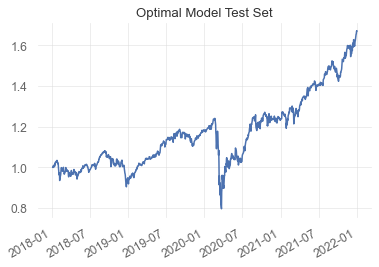

In [351]:
Portfolio_backtest(shrink_test,securities_vector=SP_test, title='Optimal Model Test Set')

                    Strategy
------------------  ----------
Start Period        2018-01-08
End Period          2021-12-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   81.25%
CAGR﹪              16.11%

Sharpe              0.81
Sortino             1.12
Sortino/√2          0.79
Omega               1.18

Max Drawdown        -36.56%
Longest DD Days     195

Gain/Pain Ratio     0.18
Gain/Pain (1M)      1.17

Payoff Ratio        0.88
Profit Factor       1.18
Common Sense Ratio  1.05
CPC Index           0.6
Tail Ratio          0.89
Outlier Win Ratio   5.19
Outlier Loss Ratio  3.98

MTD                 6.04%
3M                  10.58%
6M                  12.55%
YTD                 31.17%
1Y                  32.17%
3Y (ann.)           25.3%
5Y (ann.)           16.11%
10Y (ann.)          16.11%
All-time (ann.)     16.11%

Avg. Drawdown       -2.03%
Avg. Drawdown Days  15
Recovery Factor     2.22
Ulcer Index         0.07
Serenity Index      1.26


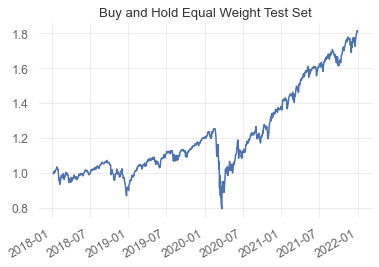

In [333]:
bnh = vanilla_markowitz_test.iloc[0:2,:]
bnh.iloc[0,:] = 1/367
bnh.iloc[1,:] = 1/367
bnh = Portfolio_backtest(bnh,securities_vector=SP_test,title='Buy and Hold Equal Weight Test Set')